In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
%load_ext autoreload
%autoreload 2
from ieee80211phy.transmitter.main import tx_generator
from ieee80211phy.receiver.packet_detector import *
from ieee80211phy.receiver.frequency_correction import *
from ieee80211phy.receiver.timing_acqusition import *
from ieee80211phy.util import *
import scipy 

import warnings
warnings.filterwarnings('ignore') # yolo!

# TX packet

Symbols: 422 Padding: 96


<IPython.core.display.Javascript object>


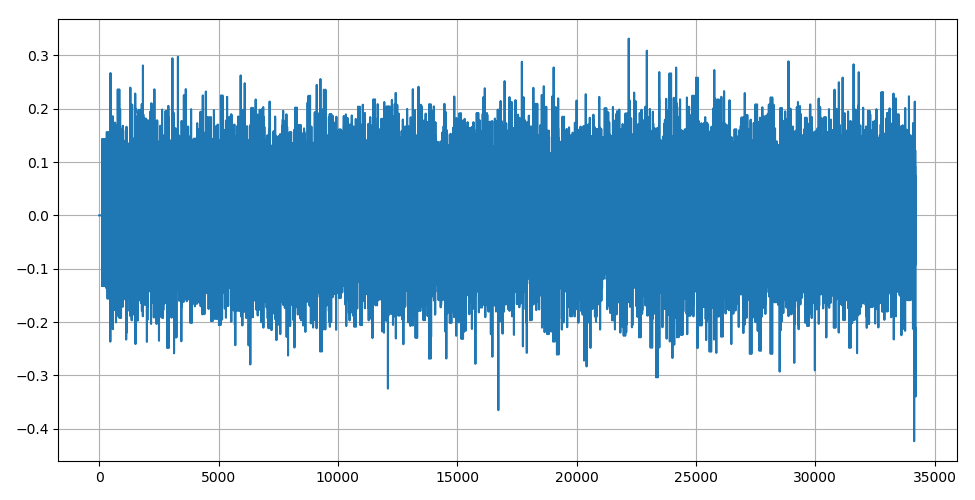

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos


<IPython.core.display.Javascript object>


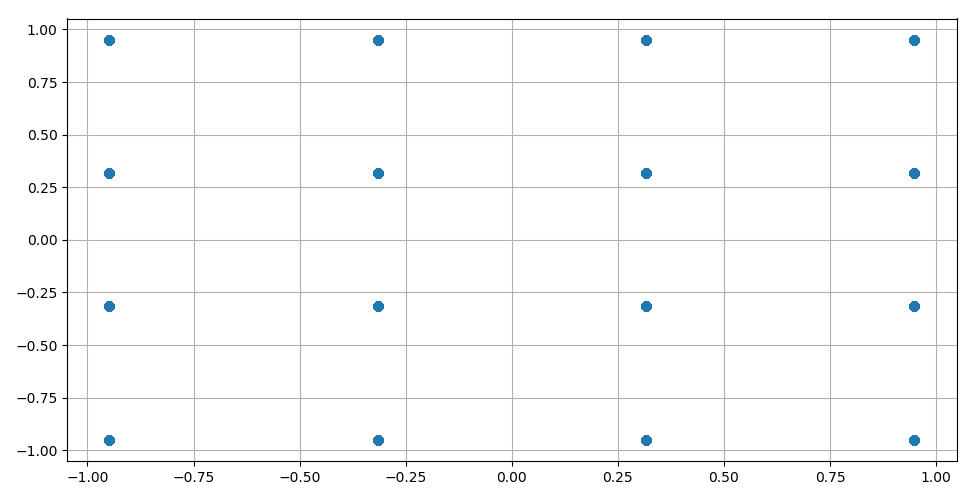

DEBUG:matplotlib.axes._base:update_title_pos


(20256,)


In [3]:
np.random.seed(0)
data = ''.join('1' if x else '0' for x in np.random.randint(2, size=80906))
tx, maps, ofdm_syms = tx_generator(data, data_rate=36)

pad_len = 128
noise = 0.00001 *  (0.70711 * np.random.randn(pad_len) + 0.70711 * np.random.randn(pad_len)*1j)
tx = np.concatenate([noise, tx])



plt.figure(figsize=(9.75,5))
plt.plot(tx)
plt.tight_layout()
plt.grid()


plt.figure(figsize=(9.75,5))
plt.scatter(maps.real, maps.imag)
plt.tight_layout()
plt.grid()
print(maps.shape)

# Channel

In [3]:
def show_freqz(taps):
    import matplotlib.pyplot as plt
    from scipy import signal
    w, h = signal.freqz(taps)
    fig, ax1 = plt.subplots(1, 1)
    plt.title('Digital filter frequency response')
    ax1.plot(w / np.pi, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency')
    plt.grid()
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w / np.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.axis('tight')
    plt.tight_layout()
    plt.show()
N = 128  # Filter order
bands = np.array([0., .22, .28, .5]) # Filter symetric around 0.25 (where .5 is pi or Fs/2)
halfband_taps =  signal.remez(N+1, bands, [1,0], [1,1])
halfband_taps[abs(halfband_taps) <= 1e-4] = 0.
show_freqz(halfband_taps)

<IPython.core.display.Javascript object>

In [4]:
def channel(tx, snr, freq_offset):
    up = scipy.signal.resample_poly(tx, 2, 1, window=halfband_taps)

    up = mixer(up, freq_offset, 40e6)
    rx = awgn(up, snr)

    rx = scipy.signal.resample_poly(rx, 1, 2, window=halfband_taps)
    return rx

def timing_offseset(tx, delay):
    step = 1
    in_index = np.arange(0, len(tx), 1)
    out_index = np.arange(0, len(tx), 1+delay)
    print(f'Max err: {delay*len(tx)}')
    print(in_index)
    print(out_index)
    
    wat = scipy.interpolate.interp1d(in_index, tx, kind='slinear', fill_value='extrapolate')
    return wat(out_index)

Max err: 3.4209
[    0     1     2 ... 34206 34207 34208]
[0.00000000e+00 1.00010000e+00 2.00020000e+00 ... 3.42064203e+04
 3.42074204e+04 3.42084205e+04]


<IPython.core.display.Javascript object>


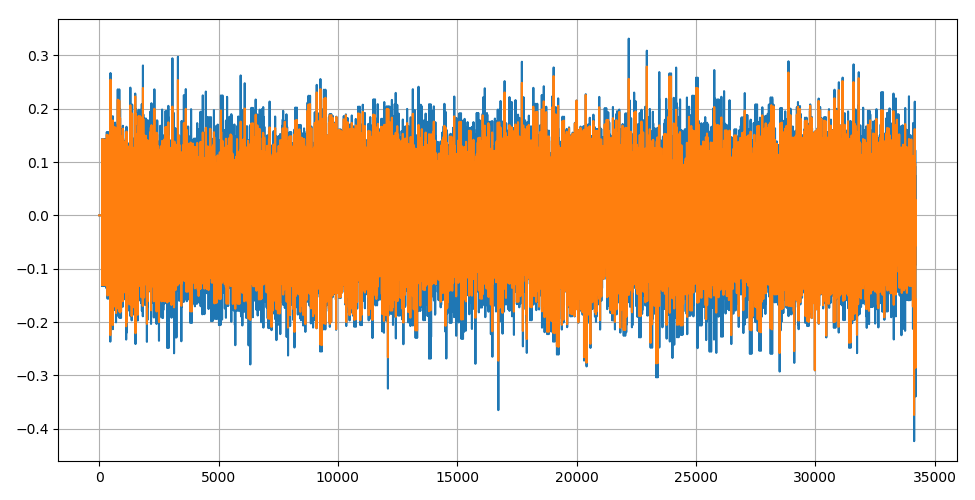

DEBUG:matplotlib.axes._base:update_title_pos


In [5]:
out = timing_offseset(tx, 0.0001)

plt.figure(figsize=(9.75,5))
plt.plot(tx)
plt.plot(out)
plt.tight_layout()
plt.grid()

In [6]:
deg = 60
rad = np.deg2rad(deg)
vec = 1.5 * np.exp(1j*rad)
print(f'Angle: {np.degrees(np.angle(vec))} Abs: {np.abs(vec)}')

rot_30 = vec * np.exp(1j*np.deg2rad(30))
print(f'Angle: {np.degrees(np.angle(rot_30))} Abs: {np.abs(rot_30)}')


r = np.arange(0, 2, 0.01)
theta = 2 * np.pi * r

plt.figure(figsize=(9.75, 5))
ax = plt.subplot(111, projection='polar')
ax.plot([0, np.angle(vec)], [0, np.abs(vec)])
ax.plot([0, np.angle(rot_30)], [0, np.abs(rot_30)])
ax.set_rmax(2)
ax.set_rticks([0.5, 1, 1.5, 2])  # less radial ticks
ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
ax.grid(True)

ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()

Angle: 59.99999999999999 Abs: 1.5000000000000002
Angle: 89.99999999999999 Abs: 1.5


<IPython.core.display.Javascript object>

# RX

In [7]:
snr = -80
(10**(snr/10.0))**.5

0.0001

In [1]:
rx = channel(tx, snr=10, freq_offset=0)
rx = timing_offseset(rx, 0.00005)
start_of_long_training, ratio = packet_detector(rx, debug=False)


from ieee80211phy.receiver.equalizer import *
equalizer = Equalizer(sample_advance=0)
equalizer.train(rx, start_of_long_training, debug=False)
# print(equalizer.equalizer_coefs)


n_symbols = 421
data_rx = rx[start_of_long_training+160:start_of_long_training+160 + (n_symbols*80)]

groups = np.reshape(data_rx, (-1, 80))
symbols = []
pilots_debug = []
slope_debug = []
pilots_angle_avg_history = []
pil2_debug = []
conj_pilots_debug = []
correcter_imag = 0.0
correcter_real = 0.0
correcter = 0.0 + 0.0j

err_debug=[0, 0, 0, 0]
imag_debug=[]
imag_after_debug=[]
coef_debug=[]
lms_step = 0.01
for symbol_number, group in enumerate(groups):
    freq = np.fft.fft(group[16:])
    equalized = equalizer.apply(freq)
    pilots = get_derotated_pilots(equalized, symbol_number+1)
    
#     print(correcter_imag)
    imag_debug.append(pilots[0].imag)
    pilots[0] += correcter
    imag_after_debug.append(pilots[0].imag)
    
    expect = 1.0 + 0.0j
    error = expect - pilots[0]
    error *= 0.25/2
    
#     try:
#         err_imag = (pilots[0].imag + err_debug[-1] + err_debug[-2] + err_debug[-3])/4
#     except:
#         err_imag = pilots[0].imag
    err_debug.append(error)
    
    correcter += error
    coef_debug.append(correcter)
        
    pilots_debug.append(pilots)
    symbols.append(demap_from_carriers(equalized))

    
    
plt.figure(figsize=(9.75, 5))
err_debug = np.array(err_debug)
plt.title('Pilots constellations')
plt.plot(err_debug.real, label='error_real')
plt.plot(err_debug.imag, label='error_imag')
# plt.plot(imag_debug, label='imag_before')
plt.plot(imag_after_debug, label='imag_after')
# plt.plot(coef_debug, label='coef')
plt.tight_layout()
plt.legend()
plt.grid()
    
pilots_debug = np.array(pilots_debug)
first_pilot = pilots_debug.T[0]
plt.figure(figsize=(9.75, 5))
plt.title('Pilots constellations')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.scatter(first_pilot.real, first_pilot.imag, label='-21')
# plt.scatter(pilots_debug.T[1].imag, pilots_debug.T[1].real, label='-7')
# plt.scatter(pilots_debug.T[2].imag, pilots_debug.T[2].real, label='7')
# plt.scatter(pilots_debug.T[3].imag, pilots_debug.T[3].real, label='21')
plt.tight_layout()
plt.legend()
plt.grid()


NameError: name 'channel' is not defined

In [9]:

# plt.figure(figsize=(9.75, 5))
# plt.title('Pilots angles')
# plt.plot(np.angle(first_pilot), label='-21')
# plt.plot(np.angle(pilots_debug.T[1]), label='-7')
# plt.plot(np.angle(pilots_debug.T[2]), label='7')
# plt.plot(np.angle(pilots_debug.T[3]), label='21')
# plt.plot(slope_debug, label='slope angle')
# plt.plot(pilots_angle_avg_history, label='avg angle')
# # plt.plot(np.abs(first_pilot))
# plt.tight_layout()
# plt.legend()
# plt.grid()

# plt.figure(figsize=(9.75, 5))
# plt.title('Pilots abs')
# plt.plot(np.abs(first_pilot), label='-21')
# plt.plot(np.abs(pilots_debug.T[1]), label='-7')
# plt.plot(np.abs(pilots_debug.T[2]), label='7')
# plt.plot(np.abs(pilots_debug.T[3]), label='21')
# plt.tight_layout()
# plt.legend()
# plt.grid()


# plt.figure(figsize=(9.75, 5))
# plt.title('Gain error Imag')
# plt.plot(first_pilot.imag, label='-21')
# plt.plot(pilots_debug.T[1].imag, label='-7')
# plt.plot(pilots_debug.T[2].imag, label='7')
# plt.plot(pilots_debug.T[3].imag, label='21')
# plt.tight_layout()
# plt.legend()
# plt.grid()

# plt.figure(figsize=(9.75, 5))
# plt.title('Gain error Real')
# plt.plot(first_pilot.real, label='-21')
# plt.plot(pilots_debug.T[1].real, label='-7')
# plt.plot(pilots_debug.T[2].real, label='7')
# plt.plot(pilots_debug.T[3].real, label='21')
# plt.tight_layout()
# plt.legend()
# plt.grid()

In [10]:
plt.figure(figsize=(9.75, 5))

aabser = np.abs(pilots_debug)
aabser = aabser.T / np.expand_dims(np.array([21, 7, 7, 21]), axis=1)
avg_abs = np.mean(aabser, axis=0)
plt.plot(np.abs(first_pilot)/21)
plt.plot(np.abs(pilots_debug.T[1])/7)
plt.plot(np.abs(pilots_debug.T[2])/7)
plt.plot(np.abs(pilots_debug.T[3])/21)
plt.plot(avg_abs)
plt.tight_layout()
plt.legend()
plt.grid()

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


In [11]:
a = np.array([1, 2, 3, 4])
b = a / [-2, -3, 4, 5]
b

array([-0.5       , -0.66666667,  0.75      ,  0.8       ])

In [12]:
from ieee80211phy.receiver.equalizer import *
equal = Equalizer(sample_advance=0)
equal.train(fixed_rx, start_of_long_training, debug=False)

rx_symbols = demod_data(fixed_rx, start_of_long_training, 109, equal, debug=True)
plot_rx(rx_symbols, ofdm_syms)

NameError: name 'fixed_rx' is not defined

In [ ]:
# rx_symbols, pilots = demod_data(fixed_rx, start_of_long_training, 109, equal)
# polarity = [1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1,
#             -1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1,
#             -1, -1,
#             1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, -1, 1,
#             -1,
#             1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, -1, -1,
#             -1, -1, -1,
#             -1, -1]

# ang1 = []
# ang2 = []
# ang3 = []
# ang4 = []
# avg = []
# for i, x in enumerate(pilots):
#     p0 = x[0] * polarity[i+1]
#     p1 = x[1] * polarity[i+1]
#     p2 = x[2] * polarity[i+1]
#     p3 = -x[3] * polarity[i+1]
    
#     avg_p = (p0 + p1 + p2 + p3) / 4
#     p_angle = np.angle(avg_p)
#     ang1.append(np.angle(x[0] * polarity[i+1]))
#     ang2.append(np.angle(x[1] * polarity[i+1]))
#     ang3.append(np.angle(x[2] * polarity[i+1]))
#     ang4.append(np.angle(-x[3] * polarity[i+1]))
# #     avg.append((ang1[-1] + ang2[-1] + ang3[-1] + ang4[-1]) / 4)
#     avg.append(p_angle)
    
    
# plt.figure(figsize=(9.75,5))
# plt.plot(ang1, label='pilot -21')
# plt.plot(ang2, label='pilot -7')
# plt.plot(ang3, label='pilot 7')
# plt.plot(ang4, label='pilot 21')
# plt.plot(avg, label='average')
# plt.tight_layout()
# plt.legend()
# plt.grid()

# mean_avg = np.mean(np.diff(avg))
# print(mean_avg, np.exp(-1j*mean_avg))


# fixed_symbols = [rx_symbols[i] * np.exp(-1j*avg[i]) for i in range(len(rx_symbols))]

# # rx_symbols = rx_symbols + np.array(avg).expand_dims()
# plot_rx(fixed_symbols, ofdm_syms)

In [ ]:
# from ieee80211phy.transmitter.ofdm_modulation import *

# no_head = rx[384+64:-1 - sample_advance]
# symbols = np.reshape(no_head, (-1, 80))
# freq = [np.fft.fft(x[16:]) for x in symbols]

# equalized = freq
# # print(equalizer_coefs)
# # equalized = [x * equalizer_coefs for x in freq]
# symbols = np.array([demap_from_carriers(x) for x in equalized])

# symbols_flat = symbols.flatten()


In [ ]:
# from ieee80211phy.util import *
# plot_rx(symbols, ofdm_syms)

In [ ]:
# plt.figure(figsize=(9.75,5))
# plt.plot(symbols)
# plt.plot(maps)
# plt.tight_layout()
# plt.grid()

In [ ]:
# from ieee80211phy.transmitter.subcarrier_modulation_mapping import *
# # symbols = np.array([QAM16_LUT_NORM[i>>2] + QAM16_LUT_NORM[i&3] * 1j for i in range(16)])
# symbols = np.array([QAM64_LUT_NORM[i>>3] + QAM64_LUT_NORM[i&7] * 1j for i in range(64)])
# print(symbols)
# pwr = [power(x) for x in symbols]
# print(pwr, np.mean(pwr))

# plt.figure(figsize=(9.75,5))
# plt.scatter(symbols.real, symbols.imag)
# plt.tight_layout()
# tick_base = 1 / np.sqrt(10)
# plt.xticks([-4*tick_base, -2*tick_base, 0, tick_base*2, tick_base*4])
# plt.yticks([-4*tick_base, -2*tick_base, 0, tick_base*2, tick_base*4])
# plt.grid()